## DCL CoCo Bonds

The following code imports data exported from Reuters, then uses it to model DCL CoCo bonds. 

In [301]:
"""
TODO: Add AT1 bond data
TODO: Find interest rates (Yield curve/credit spread?)
"""

'\nTODO: Add AT1 bond data\nTODO: Find interest rates (Yield curve/credit spread?)\n'

In [302]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf  # Cufflinks
import configparser as cp
import warnings

# Remove Eikon API depreciation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [303]:
# ================================================================
#                     Load data from Reuters
# ================================================================

def load_timeseries_data(data_folder = "data") -> pd.DataFrame: 
    """
    Load timeseries data from Reuters
    """

    close_df              = pd.read_excel(f'{data_folder}/cs_close.xlsx', index_col = 0, parse_dates = True)
    shares_outstanding_df = pd.read_excel(f'{data_folder}/cs_shares_outstanding.xlsx', index_col = 0, parse_dates = True)
    market_cap_df         = pd.read_excel(f'{data_folder}/cs_market_cap.xlsx', index_col = 0, parse_dates = True)
    total_assets_df       = pd.read_excel(f'{data_folder}/cs_total_assets.xlsx', index_col = 0, parse_dates = True)
    total_debt_df         = pd.read_excel(f'{data_folder}/cs_total_debt.xlsx', index_col = 0, parse_dates = True)
    # at1_debt_df           = pd.read_excel(f'{data_folder}/cs_at1_debt.xlsx', index_col = 0, parse_dates = True)

    # Drop duplicates
    close_df              = close_df[~close_df.index.duplicated(keep='first')]
    shares_outstanding_df = shares_outstanding_df[~shares_outstanding_df.index.duplicated(keep='first')]
    market_cap_df         = market_cap_df[~market_cap_df.index.duplicated(keep='first')]
    total_assets_df       = total_assets_df[~total_assets_df.index.duplicated(keep='first')]
    total_debt_df         = total_debt_df[~total_debt_df.index.duplicated(keep='first')]
    # at1_debt_df           = at1_debt_df[~at1_debt_df.index.duplicated(keep='first')]
    # TODO: see if we can drop duplicates in the original data

    # Fill days inbetween with the last available value
    start_date = close_df.index.min()
    end_date = close_df.index.max()
    full_range = pd.date_range(
        start=start_date - pd.DateOffset(years=1),
        end=end_date,
    )
    close_df = close_df.reindex(full_range).ffill()
    shares_outstanding_df = shares_outstanding_df.reindex(full_range).ffill()
    market_cap_df = market_cap_df.reindex(full_range).ffill()
    total_assets_df = total_assets_df.reindex(full_range).ffill()
    total_debt_df = total_debt_df.reindex(full_range).ffill()
    # at1_debt_df = at1_debt_df.reindex(full_range).ffill()

    # Remove non-business days
    full_range = pd.date_range(
        start=start_date,
        end=end_date,
        freq='B'
    )
    close_df = close_df.reindex(full_range)
    shares_outstanding_df = shares_outstanding_df.reindex(full_range)
    market_cap_df = market_cap_df.reindex(full_range)
    total_assets_df = total_assets_df.reindex(full_range)
    total_debt_df = total_debt_df.reindex(full_range)
    # at1_debt_df = at1_debt_df.reindex(full_range)
    # TODO: Remove non-business days

    # print(close_df)
    # print(shares_outstanding_df)
    # print(market_cap_df)
    # print(total_assets_df)
    # print(total_debt_df)
    # print(at1_debt_df)

    input_data = close_df.merge(shares_outstanding_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(market_cap_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_assets_df, left_index=True, right_index=True, how='left')
    input_data = input_data.merge(total_debt_df, left_index=True, right_index=True, how='left')
    # input_data = input_data.merge(at1_debt_df, left_index=True, right_index=True, how='left')

    return input_data

# # Shares outstanding from book value data:
# shares_outstanding = {
#     "2018": 2_550_600_000, 
#     "2019": 2_436_200_000, 
#     "2020": 2_406_144_879, 
#     "2021": 2_569_684_509, 
#     "2022": 3_941_250_081
# }

input_data = load_timeseries_data()

# input_data["Calculated market cap"] = input_data["Close"] * input_data["Common Shares - Outstanding - Total"]
# input_data[["Calculated market cap", "Company Market Cap"]].plot()


# input_data.plot()
input_data


,Close,Issue Default Shares Outstanding,Company Market Capitalization,Total Assets,Total Debt
2018-01-03,16.630954,2.556012e+09,4.744485e+10,7.962890e+11,2.634910e+11
2018-01-04,16.877058,2.556012e+09,4.814694e+10,7.962890e+11,2.634910e+11
2018-01-05,16.697213,2.556012e+09,4.763387e+10,7.962890e+11,2.634910e+11
2018-01-08,16.824997,2.556012e+09,4.799842e+10,7.962890e+11,2.634910e+11
2018-01-09,16.867592,2.556012e+09,4.811993e+10,7.962890e+11,2.634910e+11
...,...,...,...,...,...
2023-06-06,0.809600,4.002158e+09,3.240147e+09,5.313580e+11,1.929070e+11
2023-06-07,0.810200,4.002158e+09,3.242548e+09,5.313580e+11,1.929070e+11
2023-06-08,0.811000,4.002158e+09,3.245750e+09,5.313580e+11,1.929070e+11
2023-06-09,0.808000,4.002158e+09,3.233744e+09,5.313580e+11,1.929070e+11


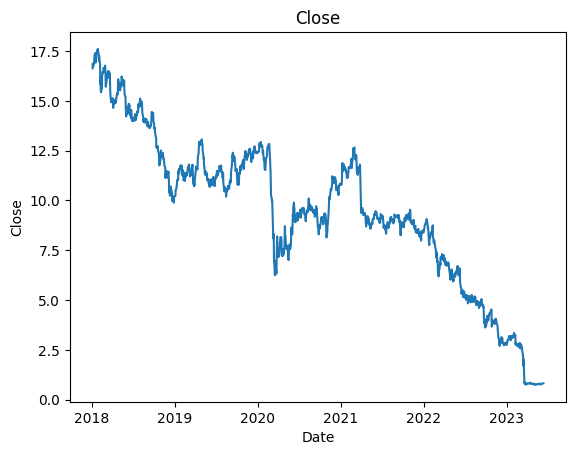

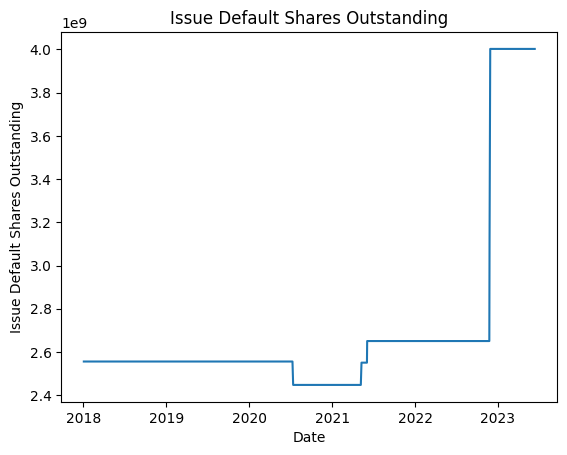

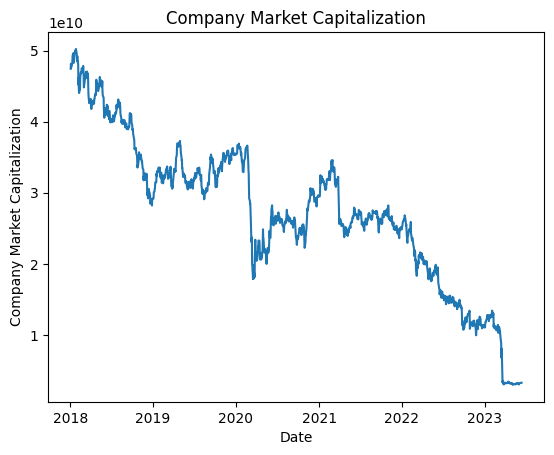

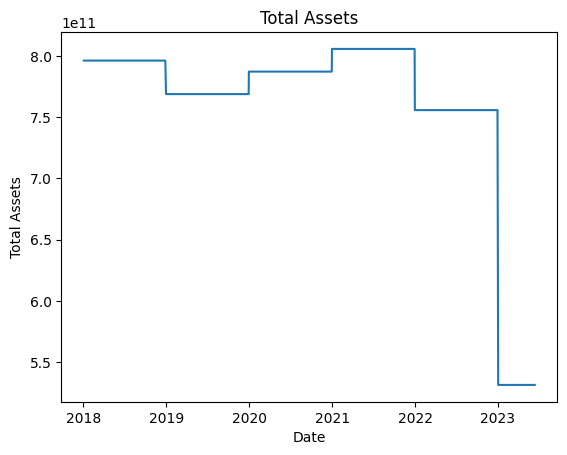

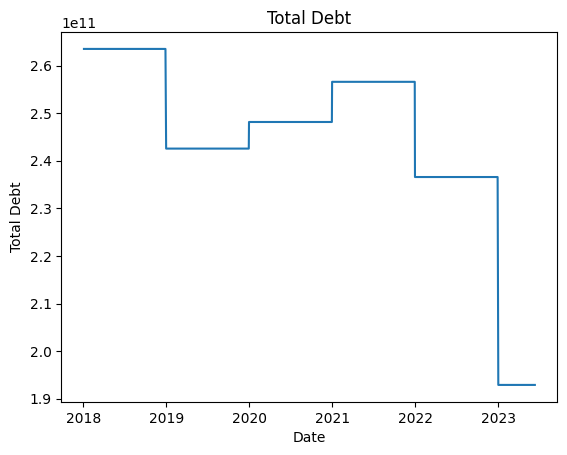

In [304]:
# ================================================================
#                        Plot the data
# ================================================================

def plot_input_data(stock_data: pd.DataFrame) -> None:
    """
    Plot the stock data. 
    """

    for col in input_data.columns:
        plt.figure()
        plt.plot(input_data.index, input_data[col])
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.savefig(f"images/{col}.png")

    plt.show()

plot_input_data(input_data)


$RQ_k = Q * ((1 + r)^k + (1 - (1 + r)^k)/(1 - (1 + r)^{-N_m}))$ (only applies if the triggers are not breached)

$L_k = \text{Total debt} / (\text{Total equity} + \text{Total debt}) = RQ_k / (RQ_k + NS_{k-1} * S_k)$

$\alpha = RQ_k / (RQ_k + \text{Book value of non CoCo debt})$

In [305]:
# ================================================================
#                    Calculate dependent variables
# ================================================================

def calculate_residual_value_of_dcl(Q, r, T_years, k_years):
    """
    Calculate the residual value of DCL bond at time k. 
    """

    return Q * ((1 + r)**k_years + (1 - (1 + r)**k_years)/(1 - (1 + r)**(-T_years)))

def calculate_alpha(RQ_k, book_value_of_non_coco_debt):
    """
    Calculate the ratio of CoCos to total debt. 
    """
    
    return RQ_k / (RQ_k + book_value_of_non_coco_debt)

def calculate_leverage_ratio(RQ_k, NS_k_1, S_k):
    """
    Calculate the leverage ratio. 
    """

    return RQ_k / (RQ_k + NS_k_1 * S_k)

def compute_period_index(dates, freq='yearly'):
    """
    Given a DatetimeIndex, returns two arrays:
       - period_array: which 'period' you are in 
       - k_array: how many 'periods' have passed since the start
    
    Depending on freq, the 'period' can be:
       - yearly:  1 step per calendar year
       - monthly: 1 step per calendar month
       - daily:   1 step per calendar day
    """
    if freq == 'daily':
        # Number of days since the start date
        base = dates[0]
        day_counts = (dates - base).days
        return day_counts, day_counts  # (period, k) are effectively the same
    
    elif freq == 'monthly':
        # A convenient measure: year*12 + month
        base_year  = dates[0].year
        base_month = dates[0].month
        
        period_array = (dates.year - base_year) * 12 + (dates.month - base_month)
        return period_array, period_array
    
    else:  # 'yearly'
        base_year = dates[0].year
        year_offset = (dates.year - base_year)
        return year_offset, year_offset

def simulate_DCL(stock_data, Q_init, r, T_years, L_min, L_c, k_freq, S_p):
    """
    Simulate the DCL model. 
    """

    period_array, k_array = compute_period_index(stock_data.index, freq=k_freq)
    # print(period_array)
    # print(k_array)
    stock_data['period'] = period_array
    # stock_data['k'] = stock_data.index.year - stock_data.index.year[0]
    stock_data['k']      = k_array

    if k_freq == 'monthly':
        period_to_years = 1.0 / 12.0
    elif k_freq == 'daily':
        period_to_years = 1.0 / 252.0
    else:
        period_to_years = 1.0

    stock_data['Book value of debt'] = stock_data['Total Debt']
    # stock_data['Shares outstanding'] = stock_data['Common Shares - Outstanding - Total']
    stock_data['Shares outstanding'] = stock_data['Issue Default Shares Outstanding']
    stock_data['Q']                  = Q_init
    stock_data['Top up loan']    = 0.0
    stock_data['New shares issued']  = 0.0
    stock_data['RQ_k']               = np.nan
    stock_data['Alpha']              = np.nan
    # stock_data['Leverage ratio']     = np.nan

    all_dates = stock_data.index
    for idx, day in enumerate(all_dates):
        if idx == 0:
            # On the very first day, we just fill RQ_k but do no rebalancing
            k_in_years = stock_data.loc[day, 'k'] * period_to_years
            stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(
                stock_data.loc[day, 'Q'],
                r,
                T_years,
                k_in_years
            )
            stock_data.loc[day, 'Alpha'] = calculate_alpha(
                stock_data.loc[day, 'RQ_k'],
                stock_data.loc[day, 'Book value of debt']
            )
            stock_data.loc[day, 'Leverage ratio'] = calculate_leverage_ratio(
                stock_data.loc[day, 'RQ_k'],
                stock_data.loc[day, 'Shares outstanding'],
                stock_data.loc[day, 'Close']
            )
            continue

        previous_day = stock_data.index[idx - 1]

        # By default, carry forward Q from prior day
        stock_data.loc[day, 'Q'] = stock_data.loc[previous_day, 'Q']

        # Compute the fraction of a year that has elapsed for this k
        k_in_years = stock_data.loc[day, 'k'] * period_to_years

        # Recompute the residual value of DCL
        stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(
            stock_data.loc[day, 'Q'], 
            r, 
            T_years, 
            k_in_years,
        )

        stock_data.loc[day, 'Payment if no breach'] = r * stock_data.loc[day, 'Q'] / (1 - (1 + r)**(-T_years))

        # Compute alpha and the leverage ratio
        stock_data.loc[day, 'Alpha'] = calculate_alpha(
            stock_data.loc[day, 'RQ_k'], 
            stock_data.loc[day, 'Book value of debt']
        )
        stock_data.loc[day, 'Leverage ratio'] = calculate_leverage_ratio(
            stock_data.loc[day, 'RQ_k'], 
            stock_data.loc[day, 'Shares outstanding'], 
            stock_data.loc[day, 'Close']
        )

        # We only rebalance once per "period" change under freq.
        # For example, if freq='monthly', this triggers once a new month starts.
        if stock_data.loc[day, 'period'] != stock_data.loc[previous_day, 'period']:
            L_k = stock_data.loc[day, 'Leverage ratio']

            if L_k < L_min:
                print(f"{day} - Leverage ratio is below minimum: L_k = {L_k}")
                stock_data.loc[day, 'Top up loan'] = -stock_data.loc[day, 'RQ_k'] + L_min * stock_data.loc[day, 'Shares outstanding'] * stock_data.loc[day, 'Close'] / (1 - L_min)
                print(f"{day} - Top up loan: {stock_data.loc[day, 'Top up loan']:,.2f}")
                stock_data.loc[day, 'Q'] = stock_data.loc[day, 'Q'] + stock_data.loc[day, 'Top up loan']

                # Recompute the residual value of DCL
                stock_data.loc[day, 'RQ_k'] = calculate_residual_value_of_dcl(
                    stock_data.loc[day, 'Q'], 
                    r, 
                    T_years, 
                    k_in_years,
                )

            elif L_k > L_c:
                print(f"{day} - Leverage ratio is above critical: L_k = {L_k}")
                stock_data.loc[day, 'New shares issued'] = stock_data.loc[day, 'Payment if no breach'] / S_p
                print(f"{day} - New shares issued: {stock_data.loc[day, 'New shares issued']}")
                stock_data.loc[day:, 'Shares outstanding'] = stock_data.loc[day:, 'Shares outstanding'] + stock_data.loc[day, 'New shares issued']

    return stock_data

L_min = 0.3     # Minimum leverage ratio
L_c = 0.6        # Critical leverage ratio
S_p = input_data['Close'][0] # Conversion price (set to be the same as the initial share price)

cs_dcl_daily = simulate_DCL(
    stock_data = input_data.copy(),
    Q_init     = 10_216_000_000, # Initial value of DCL bonds
    r          = 0.05,           # Risk free rate TODO: change to timeseries?
    T_years    = 10,             # Number of years to maturity for DCL bonds
    L_min      = L_min,          # Minimum leverage ratio
    L_c        = L_c,            # Critical leverage ratio
    k_freq     = 'daily',        # Frequency of interest payments and leverage considerations
    S_p        = S_p,            # Conversion price
)
cs_dcl_daily.to_excel("cs_dcl_daily.xlsx")

cs_dcl_monthly = simulate_DCL(
    stock_data = input_data.copy(),
    Q_init     = 10_216_000_000, # Initial value of DCL bonds
    r          = 0.05,           # Risk free rate TODO: change to timeseries?
    T_years    = 10,             # Number of years to maturity for DCL bonds
    L_min      = L_min,          # Minimum leverage ratio
    L_c        = L_c,            # Critical leverage ratio
    k_freq     = 'monthly',      # Frequency of interest payments and leverage considerations
    S_p        = S_p,            # Conversion price
)
cs_dcl_monthly.to_excel("cs_dcl_monthly.xlsx")

cs_dcl_yearly = simulate_DCL(
    stock_data = input_data.copy(),
    Q_init     = 10_216_000_000, # Initial value of DCL bonds
    r          = 0.05,           # Risk free rate TODO: change to timeseries?
    T_years    = 10,             # Number of years to maturity for DCL bonds
    L_min      = L_min,          # Minimum leverage ratio
    L_c        = L_c,            # Critical leverage ratio
    k_freq     = 'yearly',       # Frequency of interest payments and leverage considerations
    S_p        = S_p,            # Conversion price
)

# TODO: Convert T_years usage into N * n (N=T_years and n=payments per year)

cs_dcl_yearly.to_excel("cs_dcl_yearly.xlsx")
cs_dcl_yearly


2018-01-04 00:00:00 - Leverage ratio is below minimum: L_k = 0.19142828549370547
2018-01-04 00:00:00 - Top up loan: 8,274,841,712.42
2018-01-09 00:00:00 - Leverage ratio is below minimum: L_k = 0.2997651070690963
2018-01-09 00:00:00 - Top up loan: 20,660,655.07
2018-01-10 00:00:00 - Leverage ratio is below minimum: L_k = 0.2995816281074147
2018-01-10 00:00:00 - Top up loan: 36,851,348.92
2018-01-11 00:00:00 - Leverage ratio is below minimum: L_k = 0.29621663360266187
2018-01-11 00:00:00 - Top up loan: 337,601,620.57
2018-01-12 00:00:00 - Leverage ratio is below minimum: L_k = 0.2985454729179426
2018-01-12 00:00:00 - Top up loan: 131,082,947.83
2018-01-15 00:00:00 - Leverage ratio is below minimum: L_k = 0.2987146470388811
2018-01-15 00:00:00 - Top up loan: 116,466,615.99
2018-01-22 00:00:00 - Leverage ratio is below minimum: L_k = 0.298515761205988
2018-01-22 00:00:00 - Top up loan: 135,107,824.29
2018-01-23 00:00:00 - Leverage ratio is below minimum: L_k = 0.29998287678330243
2018-01-

,Close,Issue Default Shares Outstanding,Company Market Capitalization,Total Assets,Total Debt,period,k,Book value of debt,Shares outstanding,Q,Top up loan,New shares issued,RQ_k,Alpha,Leverage ratio,Payment if no breach
2018-01-03,16.630954,2.556012e+09,4.744485e+10,7.962890e+11,2.634910e+11,0,0,2.634910e+11,2.556012e+09,1.021600e+10,0.0,0.0,1.021600e+10,0.037325,0.193760,NaN
2018-01-04,16.877058,2.556012e+09,4.814694e+10,7.962890e+11,2.634910e+11,0,0,2.634910e+11,2.556012e+09,1.021600e+10,0.0,0.0,1.021600e+10,0.037325,0.191476,1.323019e+09
2018-01-05,16.697213,2.556012e+09,4.763387e+10,7.962890e+11,2.634910e+11,0,0,2.634910e+11,2.556012e+09,1.021600e+10,0.0,0.0,1.021600e+10,0.037325,0.193140,1.323019e+09
2018-01-08,16.824997,2.556012e+09,4.799842e+10,7.962890e+11,2.634910e+11,0,0,2.634910e+11,2.556012e+09,1.021600e+10,0.0,0.0,1.021600e+10,0.037325,0.191955,1.323019e+09
2018-01-09,16.867592,2.556012e+09,4.811993e+10,7.962890e+11,2.634910e+11,0,0,2.634910e+11,2.556012e+09,1.021600e+10,0.0,0.0,1.021600e+10,0.037325,0.191563,1.323019e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06,0.809600,4.002158e+09,3.240147e+09,5.313580e+11,1.929070e+11,5,5,1.929070e+11,4.002158e+09,1.554594e+10,0.0,0.0,8.716410e+09,0.043231,0.729007,2.013271e+09
2023-06-07,0.810200,4.002158e+09,3.242548e+09,5.313580e+11,1.929070e+11,5,5,1.929070e+11,4.002158e+09,1.554594e+10,0.0,0.0,8.716410e+09,0.043231,0.728860,2.013271e+09
2023-06-08,0.811000,4.002158e+09,3.245750e+09,5.313580e+11,1.929070e+11,5,5,1.929070e+11,4.002158e+09,1.554594e+10,0.0,0.0,8.716410e+09,0.043231,0.728665,2.013271e+09
2023-06-09,0.808000,4.002158e+09,3.233744e+09,5.313580e+11,1.929070e+11,5,5,1.929070e+11,4.002158e+09,1.554594e+10,0.0,0.0,8.716410e+09,0.043231,0.729397,2.013271e+09


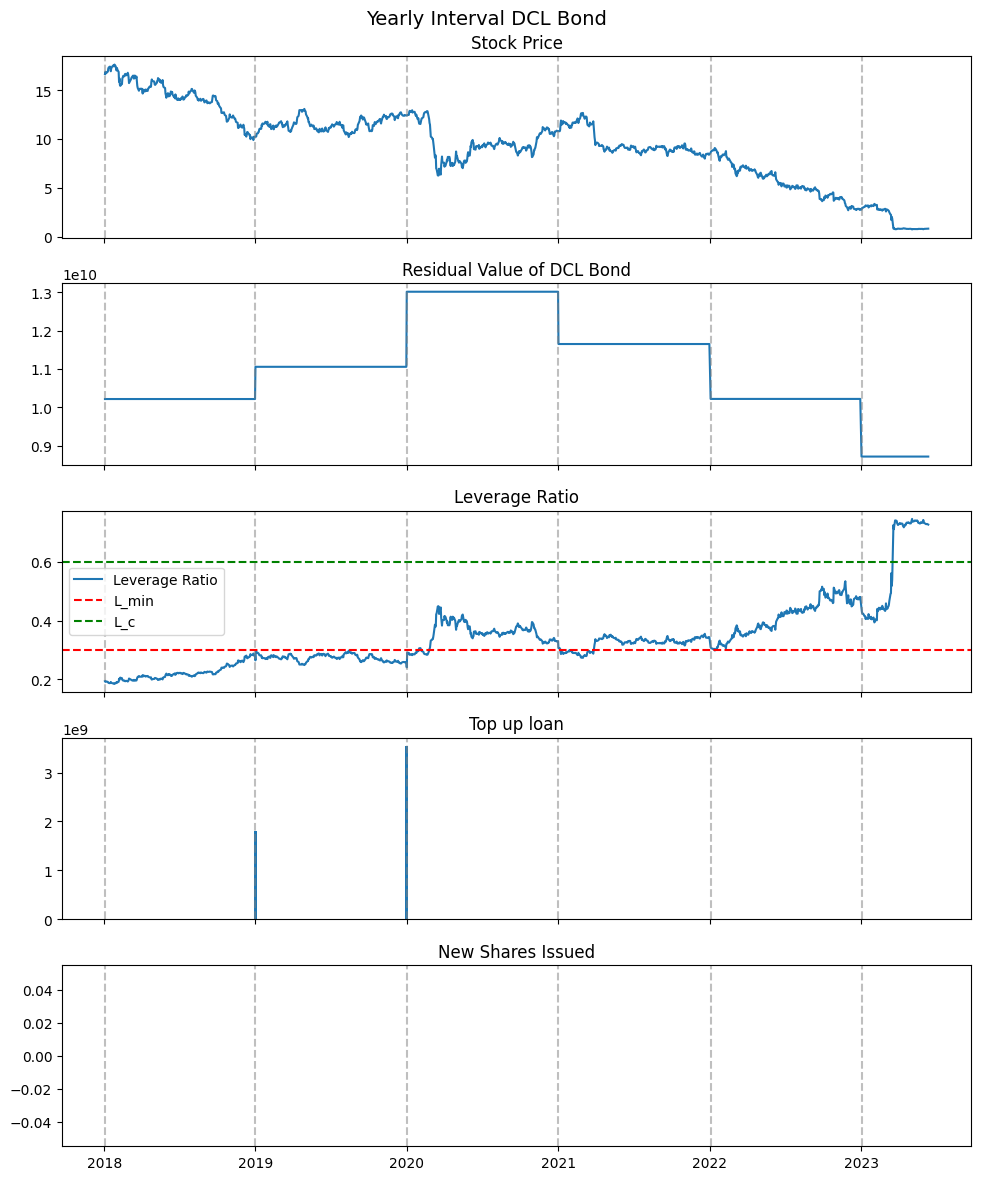

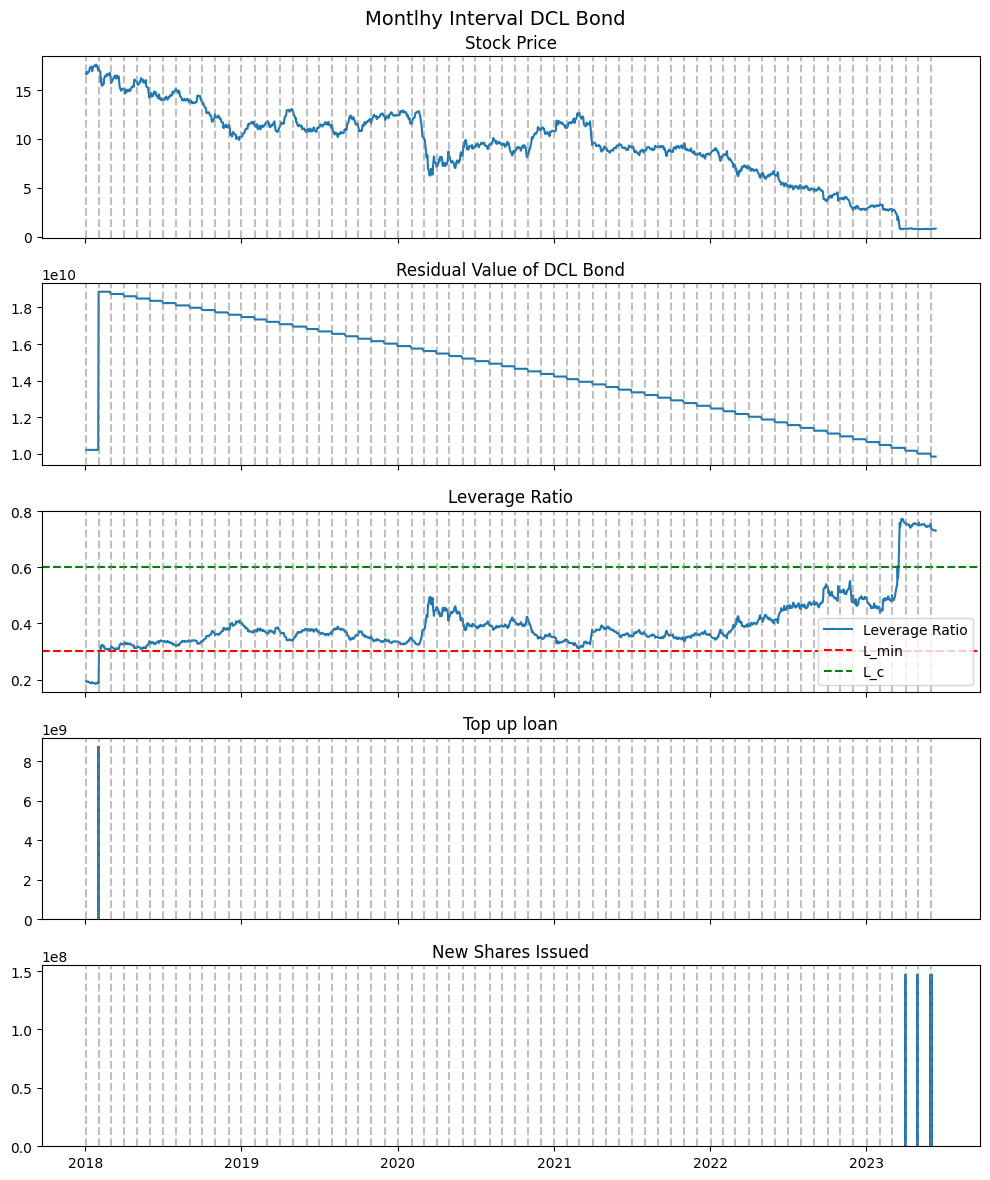

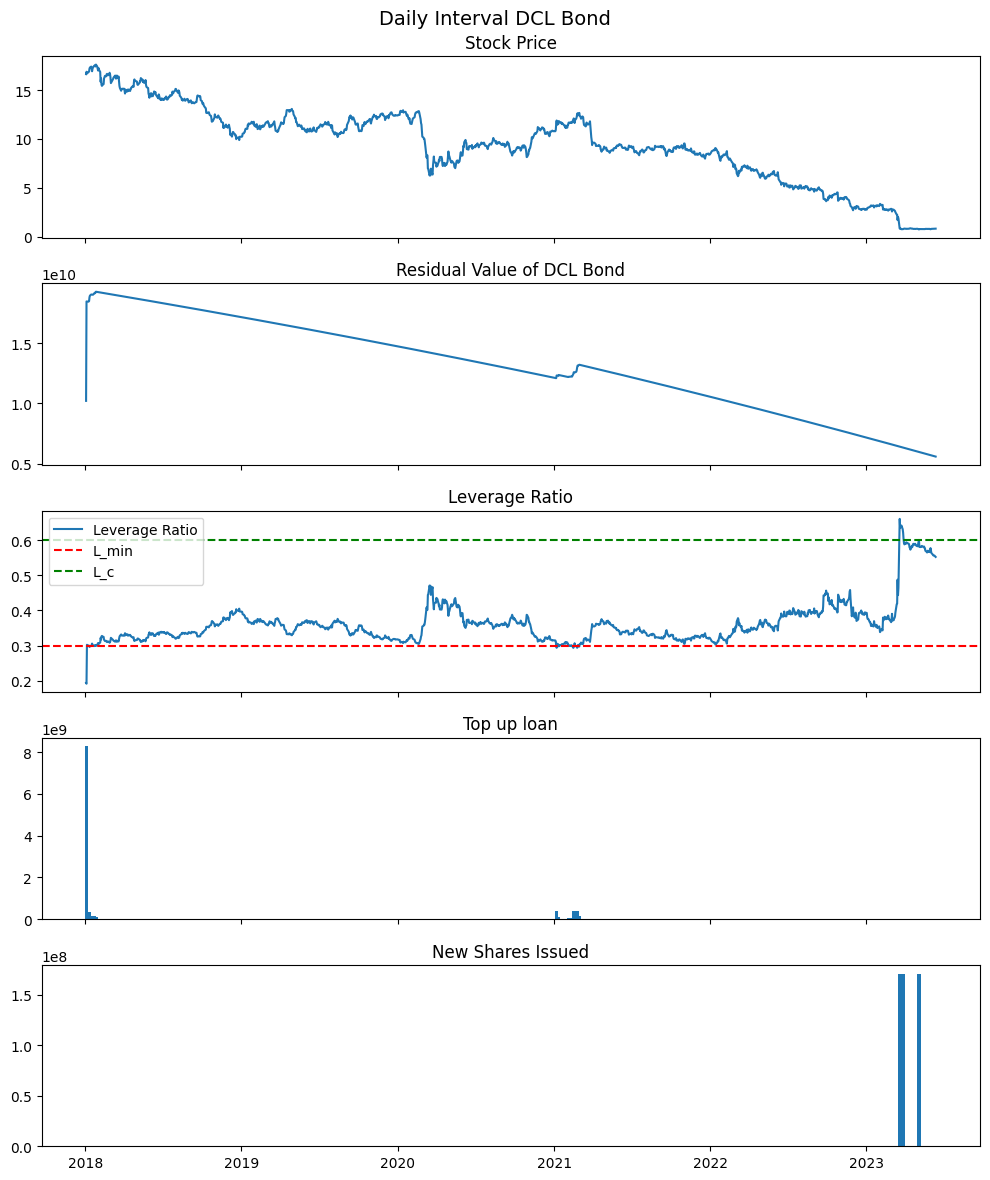

In [306]:
# ================================================================
#                        Plot the results
# ================================================================

def plot_results(df: pd.DataFrame, title) -> None:
    """
    Plot the results. 
    """

    fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,12))
    fig.suptitle(title, fontsize=14)
    

    # ------------------------------------------------------------------
    # 1) Stock price
    # ------------------------------------------------------------------
    ax[0].plot(df.index, df['Close'], label='Close')
    ax[0].set_title('Stock Price')
    # ax[0].legend(loc='best')

    # TODO: Add shares outstanding plot
    # ax[1].plot(df.index, df['Shares outstanding'], label='Shares outstanding')
    # ax[1].set_title('Shares outstanding')

    # ------------------------------------------------------------------
    # 2) Residual value of DCL bond
    # ------------------------------------------------------------------
    ax[1].plot(df.index, df['RQ_k'], label='RQ_k')
    ax[1].set_title('Residual Value of DCL Bond')
    # ax[1].legend(loc='best')

    # TODO: Add alpha plot
    # TODO: Add new debt issued plot

    # ------------------------------------------------------------------
    # 3) Leverage ratio
    # ------------------------------------------------------------------
    ax[2].plot(df.index, df['Leverage ratio'], label='Leverage Ratio')
    ax[2].axhline(y=L_min, linestyle='--', label='L_min', color='red')
    ax[2].axhline(y=L_c,   linestyle='--', label='L_c',   color='green')
    ax[2].set_title('Leverage Ratio')
    ax[2].legend(loc='best')

    # ------------------------------------------------------------------
    # 4) New Debt Issued
    # ------------------------------------------------------------------
    if 'Top up loan' in df.columns:
        ax[3].bar(df.index, df['Top up loan'], label='Top up loan', width=8)
        ax[3].set_title('Top up loan')
        # ax[3].legend(loc='best')
    else:
        ax[3].text(0.5, 0.5, 'No "Top up loan" column in DataFrame',
                   ha='center', va='center', transform=ax[3].transAxes)

    # ------------------------------------------------------------------
    # 5) New Shares Issued
    # ------------------------------------------------------------------
    if 'New shares issued' in df.columns:
        ax[4].bar(df.index, df['New shares issued'], label='New Shares Issued', width=8)
        ax[4].set_title('New Shares Issued')
        # ax[4].legend(loc='best')
    else:
        ax[4].text(0.5, 0.5, 'No "New shares issued" column in DataFrame',
                   ha='center', va='center', transform=ax[4].transAxes)

    # ------------------------------------------------------------------
    # Add vertical lines at the start of each period k
    # ------------------------------------------------------------------
    if title != "Daily Interval DCL Bond":
        for k_val in df['k'].unique():
            # For that k_val, find the first time index (i.e., the earliest date) 
            # in the DataFrame where k == k_val
            first_date_k = df[df['k'] == k_val].index[0]
            
            # You can choose on which subplot(s) you want the lines.
            # If you want the line in all subplots, iterate over `ax`. 
            # If you want it only in the last subplot, do just ax[2].axvline(...).
            for axis in ax:
                axis.axvline(first_date_k, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig("images/results.png")
    plt.show()

plot_results(cs_dcl_yearly, title="Yearly Interval DCL Bond")
plot_results(cs_dcl_monthly, title="Montlhy Interval DCL Bond")
plot_results(cs_dcl_daily, title="Daily Interval DCL Bond")
